In [2]:
from google.colab import files

# Upload the file manually
uploaded = files.upload()

# Check which files have been uploaded
import os
os.listdir("/content/")
import zipfile

# Specify the path to the uploaded ZIP file
zip_path = "/content/secondary+mushroom+dataset.zip"
extract_path = "/content/mushroom_dataset"

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Check extracted contents
os.listdir(extract_path)

# Specify the path to the nested ZIP file
nested_zip_path = os.path.join(extract_path, "MushroomDataset.zip")
nested_extract_path = os.path.join(extract_path, "MushroomDataset")

# Extract the nested ZIP file
with zipfile.ZipFile(nested_zip_path, 'r') as zip_ref:
    zip_ref.extractall(nested_extract_path)

# Check the dataset contents
dataset_path = os.path.join(nested_extract_path, "MushroomDataset")
os.listdir(dataset_path)


Saving secondary+mushroom+dataset.zip to secondary+mushroom+dataset.zip


['secondary_data.csv',
 'primary_data.csv',
 'primary_data_meta.txt',
 'secondary_data_meta.txt']

In [3]:
import pandas as pd

# Load secondary_data.csv
secondary_data_path = os.path.join(dataset_path, "secondary_data.csv")
df = pd.read_csv(secondary_data_path, delimiter=';')

# Display the first 5 rows
df.head()


,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w


In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Fill missing values with the mode (most frequent value)
df.fillna(df.mode().iloc[0], inplace=True)

# Encode the target variable 'class' (p -> 1, e -> 0)
df['class'] = df['class'].map({'p': 1, 'e': 0})

# Identify categorical and numerical features
categorical_features = [col for col in df.columns if df[col].dtype == 'object']
numerical_features = [col for col in df.columns if df[col].dtype in ['float64', 'int64']]

# Apply Label Encoding to categorical features
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Save encoders for possible decoding

# Split data into train (80%), validation (10%), and test (10%) sets
X = df.drop(columns=['class'])
y = df['class']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print dataset sizes
print("Train set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)


Train set size: (48855, 20)
Validation set size: (6107, 20)
Test set size: (6107, 20)


In [5]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        """
        Initialize a tree node.

        feature: Index of the feature used for splitting.
        threshold: Threshold value for the split.
        left: Left child (Node).
        right: Right child (Node).
        value: If the node is a leaf, it stores the predicted value (0 or 1).
        """
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value


In [6]:
import numpy as np

class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2, criterion="gini"):
        """
        max_depth: Maximum depth of the tree.
        min_samples_split: Minimum number of samples required for a split.
        criterion: 'gini' or 'entropy'.
        """
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.root = None  # Root node of the tree

    def gini(self, y):
        """Calculate Gini Impurity."""
        classes = np.unique(y)
        impurity = 1.0
        for c in classes:
            prob = np.sum(y == c) / len(y)
            impurity -= prob ** 2
        return impurity

    def entropy(self, y):
        """Calculate entropy."""
        from math import log2
        classes = np.unique(y)
        entropy = 0.0
        for c in classes:
            prob = np.sum(y == c) / len(y)
            entropy -= prob * log2(prob + 1e-9)  # Adding epsilon to avoid log(0)
        return entropy

    def best_split(self, X, y):
        """
        Finds the best feature and threshold for splitting.
        Returns (best_feature, best_threshold, best_left_idx, best_right_idx)
        """
        m, n_features = X.shape
        if m < self.min_samples_split:
            return None, None, None, None  # Do not split if there are too few samples

        best_feature, best_threshold = None, None
        best_gain = -1
        best_left_idx, best_right_idx = None, None

        # Choose the splitting criterion
        impurity_function = self.gini if self.criterion == "gini" else self.entropy
        base_impurity = impurity_function(y)

        # Iterate over all features
        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])  # Unique values of the feature
            for threshold in thresholds:
                left_idx = X[:, feature] <= threshold
                right_idx = X[:, feature] > threshold
                if np.sum(left_idx) == 0 or np.sum(right_idx) == 0:
                    continue  # Skip split if one of the nodes is empty

                # Compute impurity after the split
                left_impurity = impurity_function(y[left_idx])
                right_impurity = impurity_function(y[right_idx])
                gain = base_impurity - (len(y[left_idx]) / m * left_impurity + len(y[right_idx]) / m * right_impurity)

                # Store the best split
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold
                    best_left_idx = left_idx
                    best_right_idx = right_idx

        return best_feature, best_threshold, best_left_idx, best_right_idx

    def build_tree(self, X, y, depth=0):
        """Recursive tree building."""
        # Stopping criteria
        if len(np.unique(y)) == 1:  # All samples belong to one class
            return Node(value=y[0])
        if depth >= self.max_depth:
            return Node(value=np.bincount(y).argmax())  # Assign the most frequent class

        # Find the best split
        feature, threshold, left_idx, right_idx = self.best_split(X, y)
        if feature is None:
            return Node(value=np.bincount(y).argmax())

        # Create a node and build subtrees
        left_child = self.build_tree(X[left_idx], y[left_idx], depth + 1)
        right_child = self.build_tree(X[right_idx], y[right_idx], depth + 1)
        return Node(feature=feature, threshold=threshold, left=left_child, right=right_child)

    def fit(self, X, y):
        """Train the decision tree."""
        self.root = self.build_tree(np.array(X), np.array(y))

    def predict_sample(self, node, x):
        """Recursive prediction for a single sample."""
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self.predict_sample(node.left, x)
        else:
            return self.predict_sample(node.right, x)

    def predict(self, X):
        """Predict for all samples."""
        return np.array([self.predict_sample(self.root, x) for x in np.array(X)])

    def count_nodes(self, node=None):
        """Count the total number of nodes in the tree."""
        if node is None:
            return 0
        left_count = self.count_nodes(node.left) if hasattr(node, "left") and node.left else 0
        right_count = self.count_nodes(node.right) if hasattr(node, "right") and node.right else 0
        return 1 + left_count + right_count

    def count_leaves(self, node=None):
        """Count the number of leaves (terminal nodes)."""
        if node is None:
            return 0
        if (not hasattr(node, "left") or node.left is None) and (not hasattr(node, "right") or node.right is None):
            return 1  # This is a leaf
        left_leaves = self.count_leaves(node.left) if hasattr(node, "left") and node.left else 0
        right_leaves = self.count_leaves(node.right) if hasattr(node, "right") and node.right else 0
        return left_leaves + right_leaves

    def score(self, X, y):
        """Compute accuracy so that cross_val_score can work."""
        from sklearn.metrics import accuracy_score
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

    def get_params(self, deep=True):
        """Method for compatibility with scikit-learn."""
        return {"max_depth": self.max_depth, "min_samples_split": self.min_samples_split, "criterion": self.criterion}

    def set_params(self, **params):
        """Method for setting parameters (needed for GridSearch)."""
        for key, value in params.items():
            setattr(self, key, value)
        return self


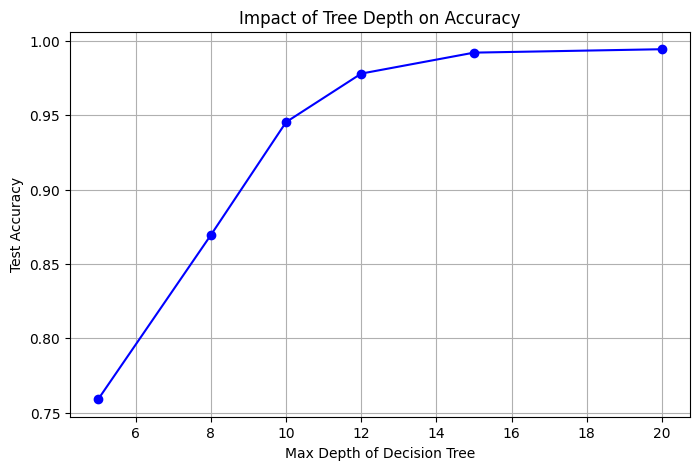

Max Depth: 5, Accuracy: 0.7591
Max Depth: 8, Accuracy: 0.8695
Max Depth: 10, Accuracy: 0.9453
Max Depth: 12, Accuracy: 0.9779
Max Depth: 15, Accuracy: 0.9920
Max Depth: 20, Accuracy: 0.9943


In [20]:
# Importing libraries
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Defining a list of max_depth values for the experiment
depth_values = [5, 8, 10, 12, 15, 20]

# List to store model accuracy scores
accuracy_scores = []

# Training the decision tree with different depths
for depth in depth_values:
    tree = DecisionTree(max_depth=depth, min_samples_split=5, criterion="gini")
    tree.fit(X_train.to_numpy(), y_train.to_numpy())  # Train on the training dataset
    y_pred = tree.predict(X_test.to_numpy())  # Make predictions on the test set
    accuracy = accuracy_score(y_test, y_pred)  # Compute accuracy
    accuracy_scores.append(accuracy)  # Store the result

# Plotting the accuracy dependency on max_depth
plt.figure(figsize=(8, 5))
plt.plot(depth_values, accuracy_scores, marker='o', linestyle='-', color='b')
plt.xlabel("Max Depth of Decision Tree")
plt.ylabel("Test Accuracy")
plt.title("Impact of Tree Depth on Accuracy")
plt.grid(True)
plt.show()

# Printing accuracy for each max_depth value
for depth, acc in zip(depth_values, accuracy_scores):
    print(f"Max Depth: {depth}, Accuracy: {acc:.4f}")


In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

# Train the model on the training data
tree = DecisionTree(max_depth=12, min_samples_split=5, criterion="entropy")
tree.fit(X_train, y_train)

# Add cross-validation (3-Fold CV)
X_train_small = X_train.sample(frac=0.8, random_state=42)
y_train_small = y_train.loc[X_train_small.index]

cv_scores = cross_val_score(tree, X_train_small, y_train_small, cv=3)
print(f"Average accuracy from 3-Fold CV: {cv_scores.mean():.4f}")
print(f"Accuracy for each of the 3 folds: {cv_scores}")

# Predictions on the training set
y_pred_train = tree.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)

# Predictions on the test set
y_pred_test = tree.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)

print(f"Accuracy on Train set: {accuracy_train:.4f}")
print(f"Accuracy on Test set: {accuracy_test:.4f}")


Average accuracy from 3-Fold CV: 0.9483
Accuracy for each of the 3 folds: [0.93636782 0.95187289 0.95663187]
Accuracy on Train set: 0.9380
Accuracy on Test set: 0.9368


In [9]:
from sklearn.metrics import confusion_matrix, classification_report

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:")
print(conf_matrix)

# Detailed classification report
class_report = classification_report(y_test, y_pred_test)
print("Classification Report:")
print(class_report)


Confusion Matrix:
[[2583  135]
 [ 251 3138]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      2718
           1       0.96      0.93      0.94      3389

    accuracy                           0.94      6107
   macro avg       0.94      0.94      0.94      6107
weighted avg       0.94      0.94      0.94      6107



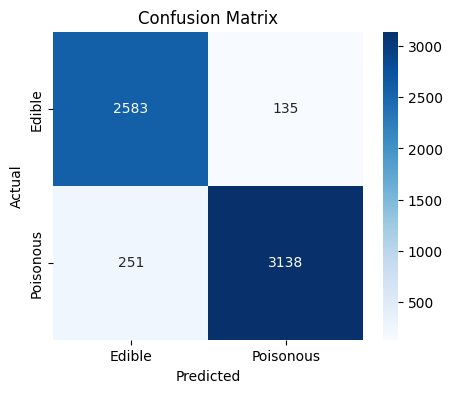

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualization of the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Edible", "Poisonous"], yticklabels=["Edible", "Poisonous"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [11]:
# Testing Gini
tree_gini = DecisionTree(max_depth=15, min_samples_split=2, criterion="gini")
tree_gini.fit(X_train, y_train)
y_pred_gini = tree_gini.predict(X_test)
accuracy_gini = accuracy_score(y_test, y_pred_gini)
print(f"Accuracy with Gini: {accuracy_gini:.4f}")

# Testing Entropy
tree_entropy = DecisionTree(max_depth=15, min_samples_split=2, criterion="entropy")
tree_entropy.fit(X_train, y_train)
y_pred_entropy = tree_entropy.predict(X_test)
accuracy_entropy = accuracy_score(y_test, y_pred_entropy)
print(f"Accuracy with Entropy: {accuracy_entropy:.4f}")


Accuracy with Gini: 0.9920
Accuracy with Entropy: 0.9941


In [12]:
# Train the model on the training data
tree = DecisionTree(max_depth=15, min_samples_split=2, criterion="entropy")
tree.fit(X_train, y_train)

# Predict on the training set
y_pred_train = tree.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)

# Predict on the test set
y_pred_test = tree.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)

print(f"Accuracy on Train set: {accuracy_train:.4f}")
print(f"Accuracy on Test set: {accuracy_test:.4f}")


Accuracy on Train set: 0.9964
Accuracy on Test set: 0.9941


In [13]:
import pandas as pd

# Predict on the test set
y_pred_test = tree.predict(X_test)

# Identify errors (where prediction != actual class)
errors = X_test[y_pred_test != y_test].copy()  # Use .copy() to avoid setting issues

# Add actual and predicted labels
errors.loc[:, "True Label"] = y_test[y_pred_test != y_test]
errors.loc[:, "Predicted Label"] = y_pred_test[y_pred_test != y_test]

# Display the first errors
print("First model errors:")
errors.head(10)  # Show the first 10 errors


First model errors:


,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,...,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season,True Label,Predicted Label
19801,6.09,6,7,1,0,2,0,4,8.73,9.18,...,7,0,4,0,1,1,4,2,1,0
44691,7.31,0,10,10,0,0,0,7,12.99,14.80,...,11,0,4,0,1,1,0,0,1,0
37299,3.52,6,3,8,0,5,0,9,5.26,6.04,...,5,0,4,1,0,1,4,0,1,0
3394,14.49,6,10,5,1,2,0,10,10.49,16.50,...,11,0,4,1,1,1,1,2,0,1
37188,3.27,6,3,4,0,5,0,5,5.62,6.32,...,6,0,4,1,0,1,4,0,1,0
56218,6.60,3,8,8,0,0,0,6,1.42,14.62,...,6,0,4,0,1,1,0,3,1,0
56169,9.33,3,8,8,0,0,0,11,1.56,14.99,...,6,0,4,0,1,1,0,0,1,0
5836,9.77,5,1,5,0,0,0,10,8.36,26.48,...,11,0,4,0,1,1,0,0,0,1
23575,5.63,2,8,9,0,0,0,10,5.17,8.94,...,11,0,4,0,1,1,0,2,1,0
56185,7.10,3,8,8,0,0,0,11,1.88,18.44,...,6,0,4,0,1,1,0,3,1,0


In [14]:
import numpy as np

def get_feature_importance(tree, feature_names):
    """Function to compute feature importance"""
    importance = np.zeros(len(feature_names))

    def traverse(node):
        """Recursively traverse the tree and count feature usage frequency"""
        if node is None or node.value is not None:
            return
        importance[node.feature] += 1
        traverse(node.left)
        traverse(node.right)

    traverse(tree.root)

    # Normalize by sum
    importance /= np.sum(importance)
    return dict(zip(feature_names, importance))

# Get feature importance
feature_importance = get_feature_importance(tree, X_train.columns)

# Display the top 10 most important features
import pandas as pd
importance_df = pd.DataFrame(sorted(feature_importance.items(), key=lambda x: x[1], reverse=True), columns=["Feature", "Importance"])
importance_df.head(10)


,Feature,Importance
0,cap-diameter,0.130208
1,cap-surface,0.119792
2,stem-width,0.119792
3,stem-height,0.098958
4,cap-color,0.078125
5,gill-attachment,0.072917
6,cap-shape,0.062500
7,gill-color,0.057292
8,stem-surface,0.052083
9,stem-color,0.052083


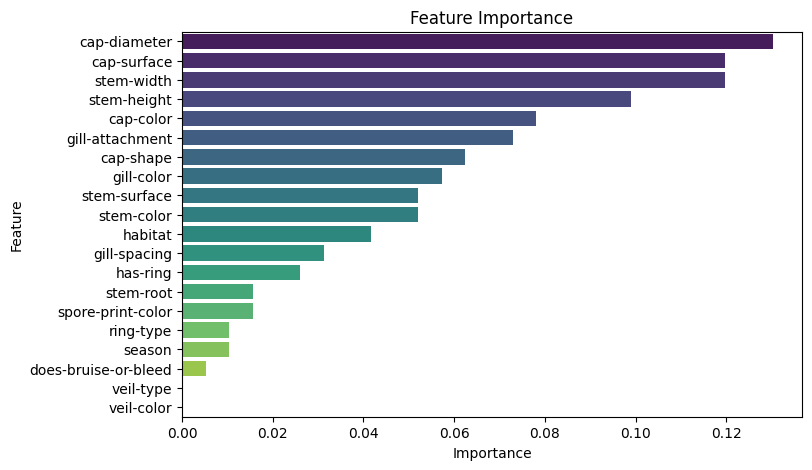

In [15]:
plt.figure(figsize=(8, 5))
sns.barplot(x="Importance", y="Feature", data=importance_df, hue="Feature", dodge=False, legend=False, palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Create and train a Random Forest model
rf = RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_split=2, random_state=42)
rf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf.predict(X_test)

# Evaluate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest model accuracy: {accuracy_rf:.4f}")


Random Forest model accuracy: 0.9993


In [17]:
# Check accuracy on the training set
y_pred_train_rf = rf.predict(X_train)
accuracy_train_rf = accuracy_score(y_train, y_pred_train_rf)

# Check accuracy on the test set
accuracy_test_rf = accuracy_score(y_test, y_pred_rf)

print(f"Accuracy on Train set: {accuracy_train_rf:.4f}")
print(f"Accuracy on Test set: {accuracy_test_rf:.4f}")


Accuracy on Train set: 0.9995
Accuracy on Test set: 0.9993


In [18]:
import joblib

# Save the trained model to a file
model_path = "/content/random_forest_mushroom.pkl"
joblib.dump(rf, model_path)

print(f"Model saved at: {model_path}")


Model saved at: /content/random_forest_mushroom.pkl


In [19]:
from google.colab import files

# Download the saved model file
files.download(model_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>